## Dataset MNIST

#### 1. Carga de datos y librerías

Este cuaderno implementa el flujo completo de entrenamiento y evaluación sobre MNIST utilizando únicamente numpy, pandas y matplotlib, junto con las clases propias de src/.

Se añade la ruta al paquete local, se importan los módulos del motor (modelo, optimizador, entrenador, pérdidas y buscador de hiperparámetros) y se carga el CSV combinado mnist.csv desde ../data/.

El fichero contiene 70 000 muestras y 785 columnas: la primera es la etiqueta (label) y las 784 restantes son las intensidades de píxeles de imágenes 28×28 en escala de grises.

In [17]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.NeuralNetwork import NeuralNetwork
from src.OptimizerAdam import OptimizerAdam
from src.Trainer import Trainer
from src.Losses import categorical_cross_entropy
from src.HyperparameterTuner import HyperparameterTuner

CSV_PATH = "../data/mnist.csv"
df = pd.read_csv(CSV_PATH)

#### 2. Procesamiento de datos

Se identifica la columna de etiqueta (label) y se separan X (características) e y (clase).
Las intensidades de píxel se normalizan a 0,1 ividiendo por 255, lo que acelera y estabiliza el entrenamiento.
Las etiquetas enteras 0…9 se transforman en codificación one-hot para obtener la matriz Y de tamaño (m,10), adecuada para la pérdida de entropía cruzada categórica con salida softmax.

Se imprime un resumen de dimensiones para verificar número de muestras, atributos y clases.

In [18]:
label_col = "label" if "label" in df.columns else df.columns[0]
y = df[label_col].to_numpy().astype(np.int64)
X = df.drop(columns=[label_col]).to_numpy().astype(np.float32)

X = X / 255.0

num_classes = int(np.max(y)) + 1
Y = np.zeros((y.size, num_classes), dtype=np.float32)
Y[np.arange(y.size), y] = 1.0

print(f"Datos cargados: {X.shape[0]} muestras, {X.shape[1]} atributos, {Y.shape[1]} clases")

Datos cargados: 70000 muestras, 784 atributos, 10 clases


#### 3. División en train/val/test

Se realiza una partición estratificada 80/10/10 manteniendo la proporción de clases en cada subconjunto y usando una semilla fija para garantizar la reproducibilidad.

Posteriormente se calcula la estandarización por característica únicamente con estadísticas del conjunto de entrenamiento (media mu y desviación sigma), y esas mismas estadísticas se aplican a validación y prueba. Este procedimiento evita fuga de información y asegura que las tres particiones estén en la misma escala que el entrenamiento.

Se imprimen las formas finales de X_train, X_val y X_test.

In [19]:
def stratified_split(y, train=0.8, val=0.1, seed=42):
    rng = np.random.default_rng(seed)
    idx_train, idx_val, idx_test = [], [], []
    for c in np.unique(y):
        idx_c = np.where(y == c)[0]
        rng.shuffle(idx_c)
        n = len(idx_c)
        n_tr = int(train * n)
        n_va = int(val * n)
        idx_train.extend(idx_c[:n_tr])
        idx_val.extend(idx_c[n_tr:n_tr+n_va])
        idx_test.extend(idx_c[n_tr+n_va:])
    return np.array(idx_train), np.array(idx_val), np.array(idx_test)

train_idx, val_idx, test_idx = stratified_split(y, 0.8, 0.1, seed=42)

X_train, Y_train = X[train_idx], Y[train_idx]
X_val,   Y_val   = X[val_idx],   Y[val_idx]
X_test,  Y_test  = X[test_idx],  Y[test_idx]

mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mu) / sigma
X_val   = (X_val   - mu) / sigma
X_test  = (X_test  - mu) / sigma

print(f"Split → Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

Split → Train: (55996, 784) | Val: (6996, 784) | Test: (7008, 784)


#### 4. Búsqueda de hiperparámetros

Se deja definido un bloque de búsqueda en rejilla (activable con RUN_TUNER = True) que explora combinaciones de:
- Tasa de aprendizaje, tamaño de lote y regularización L2
- Topologías (listas de capas ocultas) y activación
- Parámetros de Adam y dropout
- Épocas, paciencia y decaimiento del learning rate

El buscador entrena cada configuración, registra las métricas de validación y selecciona la mejor por val_acc (y, a empate, por val_loss).
Se imprime un resumen con los hiperparámetros óptimos encontrados y su identificador.

In [20]:
RUN_TUNER = False
best_cfg = None

if RUN_TUNER:
    tuner = HyperparameterTuner(X_train, Y_train, X_val, Y_val)
    results_all = []
    for e in [1, 10]:
        results = tuner.search(
            lr_list=[0.0005, 0.001, 0.003],
            batch_sizes=[64, 128],
            regs=[1e-5, 1e-4],
            hidden_layers=[[256, 128], [256, 128, 64]],
            activations=["relu"],
            betas=[(0.9, 0.999)],
            dropout_rates=[0.0, 0.2, 0.5],
            epochs=e,
            patience=8,
            decay=0.99,
            seed=42
        )
        results_all.extend(results)

    df_results = pd.DataFrame(results_all)
    best = df_results.sort_values(
        by=["best_val_acc", "best_val_loss"],
        ascending=[False, True]
    ).head(1).iloc[0].to_dict()

print("Mejor config (val):", {
    "hidden_layers": best["hidden_layers"],
    "activation":    best["activation"],
    "lr":            best["lr"],
    "batch_size":    best["batch_size"],
    "lambda_reg":    best["lambda_reg"],
    "dropout_rate":  best["dropout_rate"],
    "betas":         (best["beta1"], best["beta2"]),
    "best_val_acc":  best["best_val_acc"],
    "best_val_loss": best["best_val_loss"],
    "id":            best["id"],
})

best_cfg = best

Mejor config (val): {'hidden_layers': [256, 128, 64], 'activation': 'relu', 'lr': 0.0005, 'batch_size': 64, 'lambda_reg': 1e-05, 'dropout_rate': 0.0, 'betas': (0.9, 0.999), 'best_val_acc': 0.9634076615208691, 'best_val_loss': 0.12946228946698687, 'id': 4}


#### 5. Modelo, optimizador y entrenamiento

Se instancia una red MLP [784, 256, 128, 64, 10] con activación ReLU en las capas ocultas y softmax en la salida; pérdida CCE; inicialización Xavier; L2 λ=1e−5 y dropout desactivado.

El optimizador Adam se configura con lr=0.0005, beta1=0.9, beta2=0.999 y eps=1e-8.

El Trainer coordina el bucle de épocas con mini-lotes (batch_size=64), decaimiento del learning rate (decay=0.99) y parada temprana con patience=10. Durante el entrenamiento se almacena el historial de pérdida y precisión para entrenamiento y validación.

In [21]:
model = NeuralNetwork(
    layers=[X_train.shape[1], 256, 128, 64, Y_train.shape[1]],
    activation='relu',
    output_activation='softmax',
    loss='cce',
    seed=42,
    init='xavier',
    lambda_reg=1e-05,
    dropout_rate=0.0
)

optimizer = OptimizerAdam(lr=0.0005, beta1=0.9, beta2=0.999, eps=1e-8)
trainer = Trainer(model, optimizer, categorical_cross_entropy, patience=10, decay=0.99)
hist = trainer.train(X_train, Y_train, X_val, Y_val, epochs=30, batch_size=64)


Época 001 | Train Loss: 0.4494 | Train Acc: 87.67% | Val Loss: 0.1707 | Val Acc: 94.93%
Época 002 | Train Loss: 0.1177 | Train Acc: 96.45% | Val Loss: 0.1295 | Val Acc: 96.34%
Época 003 | Train Loss: 0.0725 | Train Acc: 97.71% | Val Loss: 0.1239 | Val Acc: 96.63%
Época 004 | Train Loss: 0.0501 | Train Acc: 98.43% | Val Loss: 0.1094 | Val Acc: 96.90%
Época 005 | Train Loss: 0.0364 | Train Acc: 98.82% | Val Loss: 0.1157 | Val Acc: 96.96%
Época 006 | Train Loss: 0.0312 | Train Acc: 99.00% | Val Loss: 0.1309 | Val Acc: 96.74%
Época 007 | Train Loss: 0.0217 | Train Acc: 99.31% | Val Loss: 0.1427 | Val Acc: 97.07%
Época 008 | Train Loss: 0.0209 | Train Acc: 99.34% | Val Loss: 0.1252 | Val Acc: 97.20%
Época 009 | Train Loss: 0.0176 | Train Acc: 99.44% | Val Loss: 0.1292 | Val Acc: 97.10%
Época 010 | Train Loss: 0.0178 | Train Acc: 99.47% | Val Loss: 0.1071 | Val Acc: 97.51%
Época 011 | Train Loss: 0.0192 | Train Acc: 99.46% | Val Loss: 0.1375 | Val Acc: 97.00%
Época 012 | Train Loss: 0.0121 |

#### 6. Evaluación y visualización

Se realiza la inferencia sobre el conjunto de prueba, se calcula la precisión final y se representan:
- La evolución de la pérdida (entrenamiento y validación) por época
- La evolución de la precisión (entrenamiento y validación) por época

Finalmente, se construye una matriz de confusión sobre el conjunto de prueba, indexada por las 10 clases (0–9), que permite identificar patrones de error típicos entre dígitos visualmente similares.

Precisión final en test: 97.40%


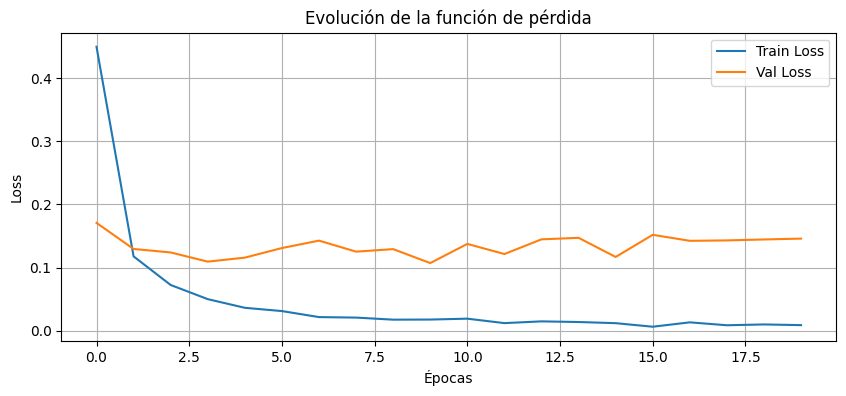

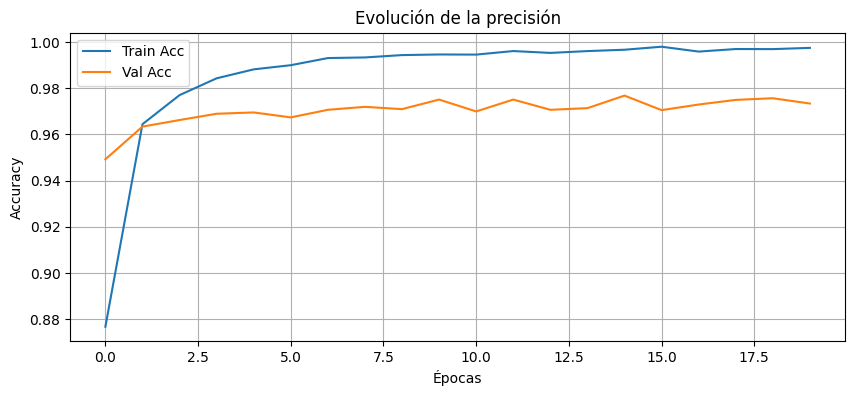

Matriz de confusión (filas=real, columnas=pred):
 0 |   680     0     2     0     2     2     2     0     2     1
 1 |     0   787     1     1     0     0     0     0     0     0
 2 |     1     4   682     3     2     1     0     2     4     0
 3 |     0     0     2   687     0    19     0     3     3     1
 4 |     0     1     4     0   666     0     3     3     4     2
 5 |     0     0     1     1     1   622     4     1     2     0
 6 |     3     0     1     0     2     5   676     0     2     0
 7 |     0     2     1     5     1     1     0   715     2     3
 8 |     1     2     4     4     2     8     3     2   653     4
 9 |     0     2     1     2    19     5     0     4     6   658


In [22]:

A_test, _ = model.forward(X_test)
y_pred = np.argmax(A_test.T, axis=1)
y_true = np.argmax(Y_test, axis=1)
accuracy_test = np.mean(y_pred == y_true)
print(f"Precisión final en test: {accuracy_test*100:.2f}%")

plt.figure(figsize=(10,4))
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"],   label="Val Loss")
plt.title("Evolución de la función de pérdida")
plt.xlabel("Épocas"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(hist["train_acc"], label="Train Acc")
plt.plot(hist["val_acc"],   label="Val Acc")
plt.title("Evolución de la precisión")
plt.xlabel("Épocas"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
plt.show()

def confusion_matrix_simple(y_true, y_pred, labels=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    n = len(labels)
    M = np.zeros((n, n), dtype=int)
    for i, t in enumerate(labels):
        for j, p in enumerate(labels):
            M[i, j] = np.sum((y_true == t) & (y_pred == p))
    print("Matriz de confusión (filas=real, columnas=pred):")
    for i, t in enumerate(labels):
        print(f"{t:>2} | " + " ".join(f"{x:5d}" for x in M[i]))
    return M

_ = confusion_matrix_simple(y_true, y_pred, labels=np.arange(num_classes))
